# Homework 5

## Part 1: Rest API 

In [1]:
suppressMessages(suppressWarnings({
    library(httr2)
    library(jsonlite)
    library(tm)
    library(wordcloud)
    library(SnowballC)
    }))

First we make a get request for the Nobel prizes in physics:

In [2]:
url <- "https://api.nobelprize.org/2.1/nobelPrizes?nobelPrizeCategory=phy"
request_object <- request(url)
response <- req_perform(request_object)
data <- resp_body_json(response)

Our task is to present the most common words in the prize motivations. To this end we first 
create a function that picks out each motivation. 

In [3]:
motivation_values <- sapply(data$nobelPrizes, function(prize) {
  sapply(prize$laureates, function(laureate) {
    laureate$motivation$en
  })
})

Since each prize could be rewarded to multiple people (and hence each prize having possibly many different motivations) we unlist our data (otherwise the wordcloud didn't work properly):

In [4]:
motivation_values <- unlist(motivation_values)

Lastly we present the most commons words in the form of a wordcloud, following the example code
that was given to us in the instructions of the homework.

In [5]:
mooncloud <- Corpus(VectorSource(motivation_values))
suppressWarnings({
    mooncloud <- tm_map(mooncloud, stripWhitespace)
    mooncloud <- tm_map(mooncloud, tolower)       
    mooncloud <- tm_map(mooncloud, removePunctuation) 
    mooncloud <- tm_map(mooncloud, removeWords, stopwords("english"))  
    mooncloud <- tm_map(mooncloud, removeNumbers) 
})

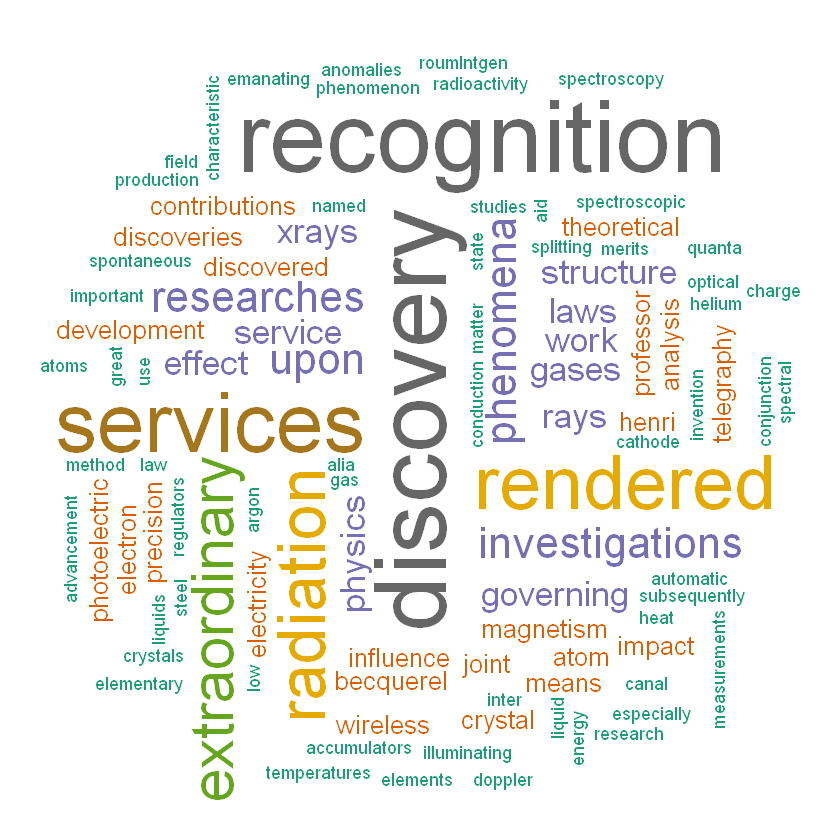

In [6]:
wordcloud(mooncloud
        , scale=c(5,0.5)     
        , max.words=100     
        , random.order=FALSE 
        , rot.per=0.35       
        , use.r.layout=FALSE 
        , colors=brewer.pal(8, "Dark2")
        , min.freq=1)

It seems like the five most common words were "discovery", "recognition", "services", "rendered" and "radiation".

## Part 2: Web scraping

In [7]:
suppressMessages(suppressWarnings({
library(tidyverse)
library(rvest)
    }))

Our task is to present a table like the one found in the homework instructions. In other words, we need
find the UPC, the title, the price and the rating for the five first books on the webpage. With this objective in mind we begin to explore the structure of the webpage. If we inspect any of the books on the main page we can find the title, the price and the rating - but not the UPC. Whilst we cannot find the UPCs on the main page, the main page contains links to detailed pages for each book (for example <https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html>). Each of these pages contains (in addition to the title, rating and price) the UPC. Now we may define a function that takes the URL associated with a book as an input and gives us the UPC, the title, the price and the rating as the output.

In [8]:
scraping_books <- function(url_book){

    
    output <- c() # We fill this empty list with each piece of information that we want
    html <- read_html(url_book)

    
    # UPC
    table <- html |>
        html_node(".table.table-striped") |> # this is the table with the UPC  
        html_table(header = FALSE)    
    output <- c(output,table$X2[table$X1 == "UPC"])

    
    # Title
    title <- html |>
        html_node("h1") |>  
        html_text()
    output <- c(output,title)

    
    # Price (the price is found in the same table as the UPC)
    output <- c(output,table$X2[table$X1 == "Price (excl. tax)"])


    # Rating
    rating <- html %>%
        html_node(".star-rating") %>%   
        html_attr("class") %>%           
        gsub("star-rating ", "", .)
    output <- c(output,rating)

    
    return(output)
    }

Using the scraping_books function defined above we could for instance see that the UPC, title, price and star rating corresponding to the first book on the main page on the webpage is 

In [9]:
scraping_books("https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html")

[1] "a897fe39b1053632"     "A Light in the Attic" "£51.77"              
[4] "Three"

We can now use the scraping_books function to retrieve all the data we need for our table. I interpret the exercise as "Scrape data for first three pages of books (books 1 through 60) and then present data for the first five books in a table similar to the one found in the homework instructions". We do that now:

In [10]:
# URLs for first three pages of books
url1 <- "https://books.toscrape.com/catalogue/category/books_1/page-1.html"
url2 <- "https://books.toscrape.com/catalogue/category/books_1/page-2.html"
url3 <- "https://books.toscrape.com/catalogue/category/books_1/page-3.html"

html1 <- read_html(url1)
html2 <- read_html(url2)
html3 <- read_html(url3)


# All urls later found via scraping are "relative" urls so we need to add them to the following "base url"
# in order to get the complete url
base_url <- "https://books.toscrape.com/catalogue/"


# Finding links for books on pages one through three and adding them together into one big vector
book_links1 <-
    html1 %>% 
    html_elements(".product_pod a") %>% 
    html_attr("href") %>% 
    str_replace(., "(../)+","") %>%
    paste0(base_url, .)
    book_links1 <- unique(book_links1)

book_links2 <-
    html2 %>% 
    html_elements(".product_pod a") %>% 
    html_attr("href") %>% 
    str_replace(., "(../)+","") %>%
    paste0(base_url, .)
    book_links2 <- unique(book_links2)

book_links3 <-
    html3 %>% 
    html_elements(".product_pod a") %>% 
    html_attr("href") %>% 
    str_replace(., "(../)+","") %>%
    paste0(base_url, .)
    book_links3 <- unique(book_links3)

book_links <- c(book_links1,book_links2,book_links3)

# Applying the scraping_books function on each book
book_data <- lapply(book_links, scraping_books)


# Collecting all scraped data in a big tibble
scraped_data <- do.call(rbind, book_data) %>%
    as_tibble() %>%
    setNames(c("UPC", "Title", "Price", "Rating"))


# Presenting a table similar to the one found in the homework instructions
print(scraped_data[1:5, ])

Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`."


# A tibble: 5 × 4
  UPC              Title                                 Price  Rating
  <chr>            <chr>                                 <chr>  <chr> 
1 a897fe39b1053632 A Light in the Attic                  £51.77 Three 
2 90fa61229261140a Tipping the Velvet                    £53.74 One   
3 6957f44c3847a760 Soumission                            £50.10 One   
4 e00eb4fd7b871a48 Sharp Objects                         £47.82 Four  
5 4165285e1663650f Sapiens: A Brief History of Humankind £54.23 Five  
